In [2]:
import json
import time
import math
from datetime import datetime
import os
from tqdm import trange, tqdm
import re
from copy import deepcopy


import csv
import unicodedata
import html
from io import StringIO
from html.parser import HTMLParser


import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from numpy import ndarray 
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split



from nptyping import NDArray, Int, Shape
from typing import Dict, List, Tuple, Union




from piazza_api import Piazza
from piazza_api.network import Network

"""Custom Types"""
Answer = Dict[str,Dict[str,Union[str,int]]]
Post = Dict[str,Union[str, Union[str,int,List]]]

"""Macros"""
# who the answer is coming from
STUDENT, INSTRUCTOR, STUDENT_ENDORSED_ANSWERER = 0, 1, 2
EPSILON = 1e-05

In [3]:
ANALYSIS_FILEPATH = "./csc108_fall2021_sentiment_aug.csv"
final_data = pd.read_csv(ANALYSIS_FILEPATH).set_index('ID')
#final_data
y_train = final_data['is_helpful']
X_train = final_data.drop(labels=["is_helpful"], axis=1)

X_train

,post_id,is_private,category,student_poster_id,question_length,is_question_references,question_lod,question_sentiment,is_followup,answerer_id,answer_length,is_answer_references,answer_lod,answer_sentiment,response_time,reputation
ID,,,,,,,,,,,,,,,,
0,3809.0,1.0,0.0,0.0,23.0,0.0,0.0,1.0,0.0,1.0,27.0,0.0,0.0,1.0,43.0,1.0
1,3808.0,0.0,0.0,2.0,53.0,0.0,0.0,0.0,0.0,3.0,48.0,0.0,0.0,1.0,6.0,0.0
2,3807.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,5.0,3.0,1.0,0.0,1.0,2.0,0.0
3,3807.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,43.0,1.0,0.0,0.0,3.0,1.0
4,3806.0,1.0,0.0,6.0,93.0,0.0,0.0,0.0,1.0,7.0,32.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,15.0,0.0,0.0,600.0,147.0,0.0,0.0,1.0,1.0,624.0,44.0,0.0,0.0,1.0,1695.0,0.0
3496,13.0,1.0,2.0,600.0,24.0,0.0,0.0,0.0,1.0,600.0,30.0,0.0,0.0,1.0,69.0,0.0
3497,13.0,1.0,2.0,600.0,24.0,0.0,0.0,0.0,1.0,452.0,143.0,0.0,0.0,1.0,99.0,1.0


### Feature Distributions 

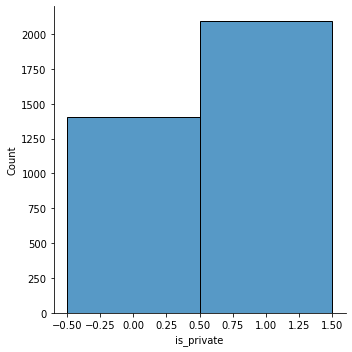

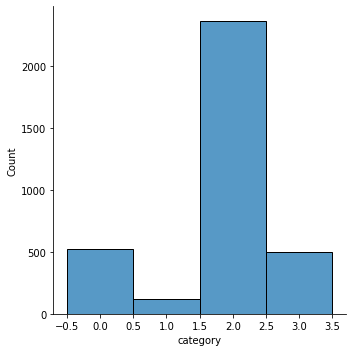

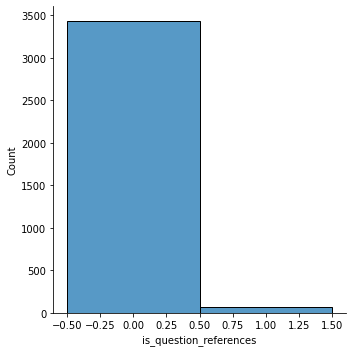

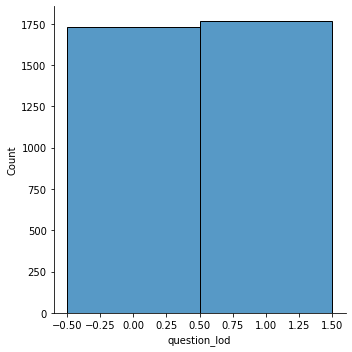

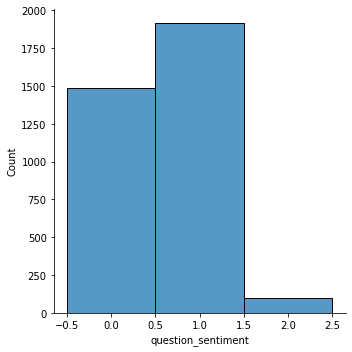

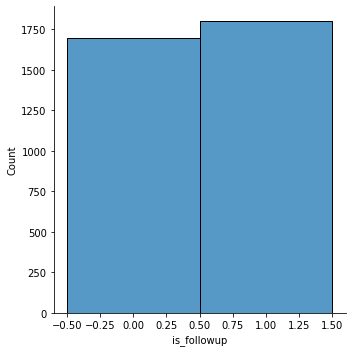

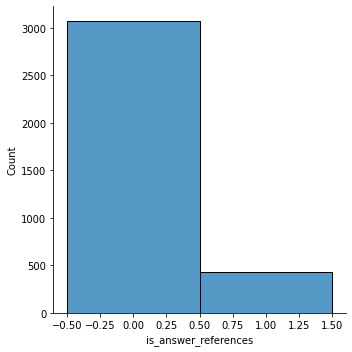

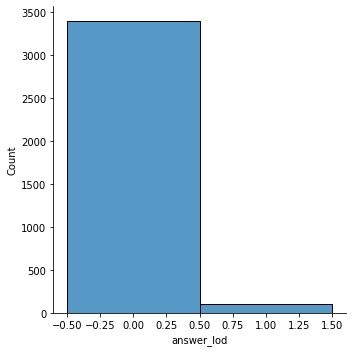

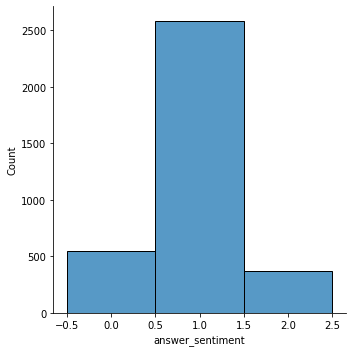

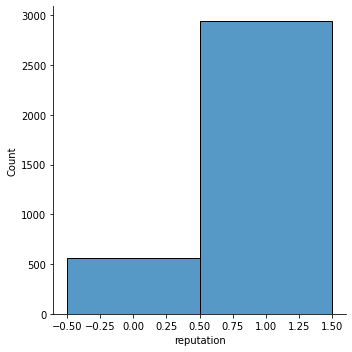

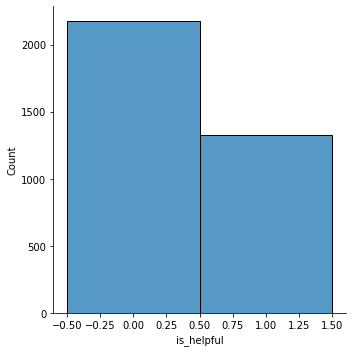

In [4]:
def plot_discrete_distributions(dataset: DataFrame, continuous_features: set, hue=None) -> None:
    """
    :param hue: None, is_helpful, set where set indicates the type of dataset
    """
    features = dataset.keys()
    for f in features:
        if f not in continuous_features:
            if hue:
                sns.displot(data=dataset, x=f"{f}",  kind="hist", discrete=True, binwidth=1, hue=hue)
            else:
                sns.displot(data=dataset, x=f"{f}",  kind="hist", discrete=True, binwidth=1)

   
   

continuous_features = {'question_length', 'answer_length', 'response_time', 'post_id', 'student_poster_id', 'answerer_id'}

plot_discrete_distributions(final_data, continuous_features, hue=None)

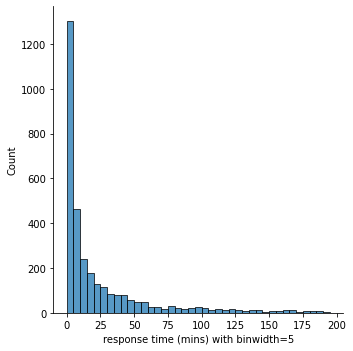

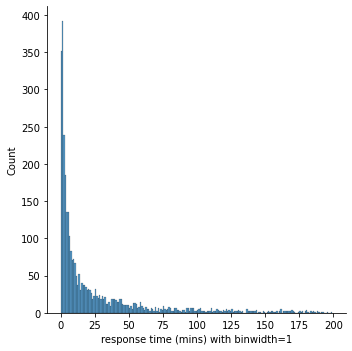

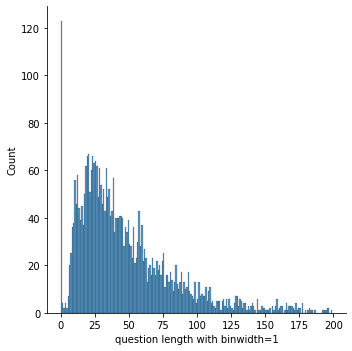

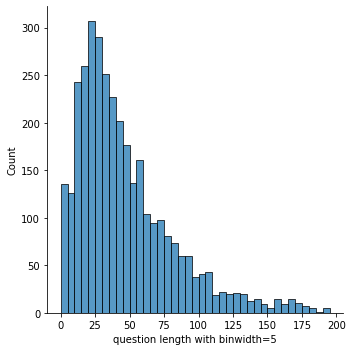

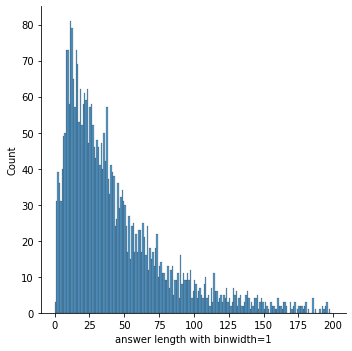

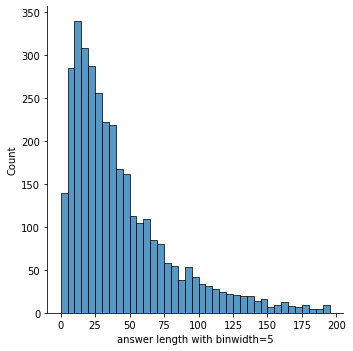

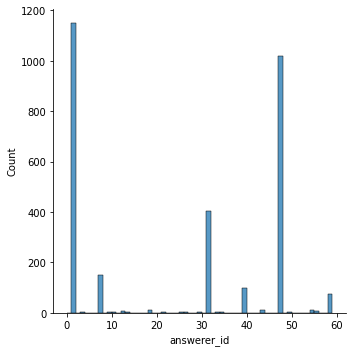

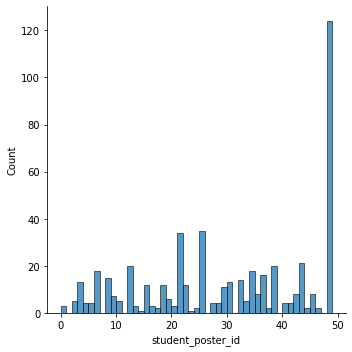

In [5]:
def plot_continuous_distributions(dataset: DataFrame, hue=None) -> None:


    #sns.displot(data=final_data, x=f"response_time",  kind="hist", bins=[0, 100, 200, 300, 400, 100000])
    #sns.displot(data=final_data, x=f"response_time",  kind="hist", binwidth=100)
    a = np.arange(0, 200, 5)
    b = np.arange(0, 200, 1)

    ax = sns.displot(data=dataset, x=f"response_time",  kind="hist", bins=a, hue=hue)
    ax.set_xlabels('response time (mins) with binwidth=5')

    ax=sns.displot(data=dataset, x=f"response_time",  kind="hist", bins=b,hue=hue)
    ax.set_xlabels('response time (mins) with binwidth=1')

    c = np.arange(0, 200, 1)
    c1 = np.arange(0, 200, 5)

    ax=sns.displot(data=dataset, x=f"question_length",  kind="hist", bins=c,hue=hue)
    ax.set_xlabels('question length with binwidth=1')
    ax=sns.displot(data=dataset, x=f"question_length",  kind="hist", bins=c1, hue=hue)
    ax.set_xlabels('question length with binwidth=5')


    ax=sns.displot(data=dataset, x=f"answer_length",  kind="hist", bins=c,hue=hue)
    ax.set_xlabels('answer length with binwidth=1')
    ax=sns.displot(data=dataset, x=f"answer_length",  kind="hist", bins=c1,hue=hue)
    ax.set_xlabels('answer length with binwidth=5')

    d= np.arange(0, 60, 1)
    e= np.arange(0, 50, 1) # take random sampling of 50
    ax=sns.displot(data=dataset, x=f"answerer_id",  kind="hist", bins=d, hue=hue)
    ax=sns.displot(data=dataset, x=f"student_poster_id",  kind="hist", bins=e, hue=hue)

# add helpful as a 3rd axis
# check for rlnship b/w question/answerer and is/is not helpful

plot_continuous_distributions(final_data, hue=None)

### Mutual Information

mi feature names is: ['student_poster_id', 'post_id', 'answerer_id', 'answer_length', 'question_length', 'is_followup']
mi score_indices is [3, 0, 9, 10, 4, 8]


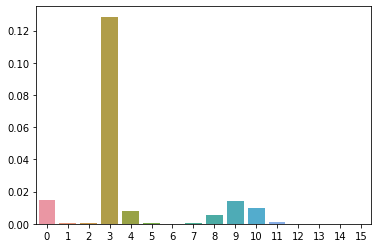

In [62]:
from functools import partial

y_train = final_data['is_helpful']
X_train = final_data.drop(labels=["is_helpful"], axis=1)


def filter_dataset(dataset: DataFrame, features_to_keep: set):
    pass

def mutual_info_score(X_train, y_train, continuous_features: set, num_samples = 10) -> List[float]:
    features = list(X_train.keys())
    discrete_indices = list(range(0, len(features)))

    # Remove continuous index features: q&a length, response time, post id, student/answerer id
    for f in continuous_features:
        discrete_indices.remove(features.index(f))

    scores = None
    for i in range(num_samples):
        if i == 0:
            scores = mutual_info_classif(X_train, y_train, discrete_features=discrete_indices)
            #scores = fs.fit(X_train, y_train).scores_
        else:
            scores = mutual_info_classif(X_train, y_train, discrete_features=discrete_indices)
            #scores += fs.fit(X_train, y_train).scores_

    scores = scores / num_samples
    scores = scores.tolist()
    return scores

def chi2_score(X_train, y_train) -> List[float]:
    """
    Measures dependence between categorical variables
    """
    pass

 

    #return mutual_info_classif(X_train, y_train, discrete_features=discrete_indices)

def plot_scores(X_train, y_train, select_k_best='all', num_samples=10, continuous_features:set=None, seed=0, score_func=mutual_info_classif):
    """
    Determine and plot MI scores b/w train data and targets. MI is useful since it works for both discrete and continuous features.
    Chi-squared test only makes sense for discrete, nominal (as opposed to ordinal) features.

    Can still run chi-squared on a subset of the features.
    """

    features = list(X_train.keys())



    if score_func == mutual_info_classif:
        discrete_indices = list(range(0, len(features)))
        # Remove continuous index features: q&a length, response time, post id, student/answerer id
        for f in continuous_features:
            discrete_indices.remove(features.index(f))

        score_func = partial(mutual_info_classif, discrete_features=discrete_indices, random_state=seed)


    if select_k_best == 'all':
        select_k_best = len(features)

    scores = score_func(X_train, y_train)

    # scores = None
    # for i in range(num_samples):
    #     if i == 0:
    #         scores = score_func(X_train, y_train)
    #         #scores = fs.fit(X_train, y_train).scores_
    #     else:
    #         scores += score_func(X_train, y_train)
    #         #scores += fs.fit(X_train, y_train).scores_

    # print(scores)
    # scores = scores / num_samples
    scores = scores.tolist()

    sns.barplot(x=list(range(0, len(features))), y=scores)
    #sns.barplot(x=list(range(0, len(features))), y=my_chi_scores)

    # Retrive top-k stores 

    sorted_scores = sorted(scores, reverse=True)
    features = X_train.keys()
    score_indices = []
    feature_names = []

    for i in range(select_k_best):
        score_index = scores.index(sorted_scores[i])
        score_indices.append(score_index)
        feature_names.append(features[score_index])
    
    return feature_names, score_indices

    
#fs = plot_mutual_info(X_train, y_train, continuous_features, select_k_best=5)
# feature_names, score_indices = plot_mutual_info(X_train, y_train, continuous_features, select_k_best=6)

mi_feature_names, mi_score_indices = plot_scores(X_train, y_train, continuous_features=continuous_features, select_k_best=6)

print(f"mi feature names is: {mi_feature_names}\nmi score_indices is {mi_score_indices}")

#X_train_continuous = X_train.drop(list(continuous_features), axis=1)

#chi2_feature_names, chi2_score_indices = plot_scores(X_train_continuous, y_train, select_k_best=6, score_func=chi2)








In [51]:
X_train

,post_id,is_private,category,student_poster_id,question_length,is_question_references,question_lod,question_sentiment,is_followup,answerer_id,answer_length,is_answer_references,answer_lod,answer_sentiment,response_time,reputation
ID,,,,,,,,,,,,,,,,
0,3809.0,1.0,0.0,0.0,23.0,0.0,0.0,1.0,0.0,1.0,27.0,0.0,0.0,1.0,43.0,1.0
1,3808.0,0.0,0.0,2.0,53.0,0.0,0.0,0.0,0.0,3.0,48.0,0.0,0.0,1.0,6.0,0.0
2,3807.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,5.0,3.0,1.0,0.0,1.0,2.0,0.0
3,3807.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,43.0,1.0,0.0,0.0,3.0,1.0
4,3806.0,1.0,0.0,6.0,93.0,0.0,0.0,0.0,1.0,7.0,32.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,15.0,0.0,0.0,600.0,147.0,0.0,0.0,1.0,1.0,624.0,44.0,0.0,0.0,1.0,1695.0,0.0
3496,13.0,1.0,2.0,600.0,24.0,0.0,0.0,0.0,1.0,600.0,30.0,0.0,0.0,1.0,69.0,0.0
3497,13.0,1.0,2.0,600.0,24.0,0.0,0.0,0.0,1.0,452.0,143.0,0.0,0.0,1.0,99.0,1.0


### Split into train, val and test datasets

In [74]:
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"

TRAIN_RELEVANT_FEATURES_PATH = "train_relevant_features.csv"
TEST_RELEVANT_FEATURES_PATH = "test_relevant_features.csv"


# unique q&a posters


y_train = final_data['is_helpful']
X_train = final_data.drop(labels=["is_helpful"], axis=1)


#try removing features and keeping only relevant ones based on mi scores. Compare performance.
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=0, stratify=y_train)

X_train["is_helpful"] = y_train
X_test["is_helpful"] = y_test

X_train["set"] = "train" 
X_test["set"] = "test" 

combined_datasets = pd.concat([X_train, X_test])


#plot_discrete_distributions(combined_datasets, continuous_features, hue="set")
#plot_continuous_distributions(combined_datasets, hue="set")

final_data


,post_id,is_private,category,student_poster_id,question_length,is_question_references,question_lod,question_sentiment,is_followup,answerer_id,answer_length,is_answer_references,answer_lod,answer_sentiment,response_time,reputation,is_helpful
ID,,,,,,,,,,,,,,,,,
0,3809.0,1.0,0.0,0.0,23.0,0.0,0.0,1.0,0.0,1.0,27.0,0.0,0.0,1.0,43.0,1.0,0.0
1,3808.0,0.0,0.0,2.0,53.0,0.0,0.0,0.0,0.0,3.0,48.0,0.0,0.0,1.0,6.0,0.0,0.0
2,3807.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,5.0,3.0,1.0,0.0,1.0,2.0,0.0,0.0
3,3807.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,43.0,1.0,0.0,0.0,3.0,1.0,0.0
4,3806.0,1.0,0.0,6.0,93.0,0.0,0.0,0.0,1.0,7.0,32.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,15.0,0.0,0.0,600.0,147.0,0.0,0.0,1.0,1.0,624.0,44.0,0.0,0.0,1.0,1695.0,0.0,0.0
3496,13.0,1.0,2.0,600.0,24.0,0.0,0.0,0.0,1.0,600.0,30.0,0.0,0.0,1.0,69.0,0.0,0.0
3497,13.0,1.0,2.0,600.0,24.0,0.0,0.0,0.0,1.0,452.0,143.0,0.0,0.0,1.0,99.0,1.0,0.0


In [73]:
#X_train.to_csv(TRAIN_PATH)
#X_test.to_csv(TEST_PATH)

In [13]:
final_data
private = final_data[final_data['is_private'] == True] 
private_helpful = private[private['is_helpful'] == True]
private_not_helpful = private[private['is_helpful'] == False]

public = final_data[final_data['is_private'] == False] 
public_helpful = public[public['is_helpful'] == True]
public_not_helpful = public[public['is_helpful'] == False]
#public = final_data[final_data['is_private'] == False]

positive = final_data[final_data['question_sentiment'] == 2.0] 
neutral = final_data[final_data['question_sentiment'] == 1.0] 
negative = final_data[final_data['question_sentiment'] == 0.0] 
# public_helpful = public[public['is_helpful'] == True]
# public_not_helpful = public[public['is_helpful'] == False]

#print(len(public_helpful))
#print(len(public_not_helpful))

#len(final_data[final_data['answerer_id'] == 5]) #1149
#len(final_data['answerer_id'])

print(len(positive))
print(len(neutral))
print(len(negative))

98
1915
1487


- response time bins
  - 0, 1, 5,10, 100, 200, 300, 400, ... , 1000, 2000, 3000, 4000, over 5000